In [82]:
from patch.utils import embed_to_distrib, top_vals, format_token, intervene_node_and_pos
from patch.models.gpt2 import GPT2, create_gpt2
import sys

config, tokenizer, model = create_gpt2('gpt2-medium')
model = GPT2(config, model, verbose=False)

loaded model


In [86]:
inputs = [
    tokenizer("Jane is my friend.", return_tensors="pt"),
    tokenizer("John is my friend.", return_tensors="pt")
]
print(inputs)
assert len(inputs[0]['input_ids'][0]) == len(inputs[1]['input_ids'][0])

[{'input_ids': tensor([[41083,   318,   616,  1545,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}, {'input_ids': tensor([[7554,  318,  616, 1545,   13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}]


In [87]:
res1, cache1 = model(inputs, which=lambda x: 0, verbose=False)
distrib1 = embed_to_distrib(model, res1.hidden_states, logits=False)
top_vals(tokenizer, distrib1[0][-1], n=10)
print('-----')

res2, cache2 = model(inputs, which=lambda x: 1, verbose=False)
distrib2 = embed_to_distrib(model, res2.hidden_states, logits=False)
top_vals(tokenizer, distrib2[0][-1], n=10)

_She                 0.2067352831363678
_I                   0.19786357879638672
\n                   0.07616224139928818
_And                 0.03331829234957695
_You                 0.026229754090309143
_We                  0.024915628135204315
_It                  0.024322494864463806
_My                  0.018620695918798447
_If                  0.01579582504928112
_But                 0.013011446222662926
-----
_He                  0.26240184903144836
_I                   0.21843186020851135
\n                   0.04855649918317795
_We                  0.037349049001932144
_And                 0.03207528218626976
_It                  0.021036285907030106
_You                 0.020694827660918236
_My                  0.017431046813726425
_If                  0.015306632965803146
_But                 0.013927387073636055


100%|██████████| 49/49 [01:03<00:00,  1.29s/it]


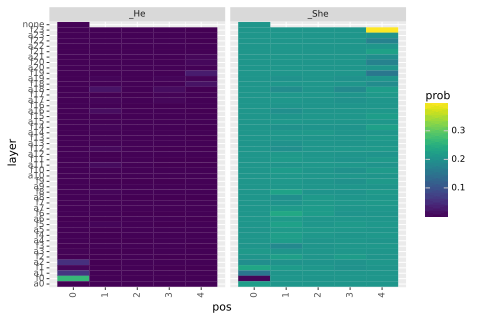

In [88]:
%config InlineBackend.figure_formats = ['svg']

df, nodes, g = intervene_node_and_pos(model, tokenizer, inputs, tokens=[' She', ' He'], plot=True, pause=False)
print(g)

In [89]:
# top interventions for He
df[df.token == '_He'].sort_values('prob', ascending=False).head(10)

,token,prob,layer,pos,id
463,_He,0.262458,f0,0,47
453,_He,0.064685,a1,0,46
433,_He,0.060058,a2,0,44
91,_He,0.034980,f19,4,9
115,_He,0.027118,a18,1,12
111,_He,0.025037,f18,4,11
155,_He,0.019539,a16,1,16
119,_He,0.018594,a18,3,12
255,_He,0.017910,a11,1,26
71,_He,0.015150,f20,4,7


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_42972/2508984861.py:34: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


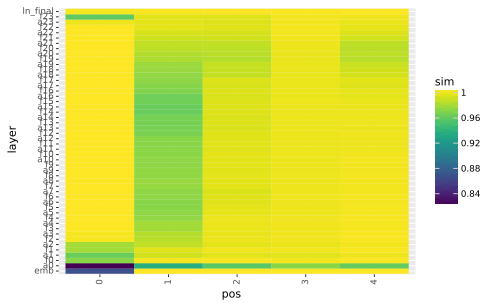

In [90]:
import torch
import pandas as pd
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text

data = []

for key in cache1:
    if 'head' in key.parent:
        continue
    ret1 = cache1[key].hidden_states
    for key2 in cache2:
        if key2.parent == key.parent:
            ret2 = cache2[key2].hidden_states

    # get cosine similarity
    sim = torch.nn.functional.cosine_similarity(ret1, ret2, dim=-1)
    for tok in range(sim.shape[1]):
        data.append({
            'layer': key.parent,
            'pos': tok,
            'sim': sim[0, tok].item()
        })

layers = config.n_layer
order = ["emb"]
for i in range(layers):
    order.append(f"a{i}")
    order.append(f"f{i}")
order.append("ln_final")

df = pd.DataFrame(data)
df["pos"] = df["pos"].astype("category")
df["layer"] = df["layer"].astype("category")
df["layer"].cat.reorder_categories(order, inplace=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="sim", color="sim"))
    + theme(axis_text_x=element_text(rotation=90))
)
print(g)